# Etape_2 : Préparez la veille technique en NLP ou en computer vision :

In [1]:
# preparing datasets

from pathlib import Path
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DeiTFeatureExtractor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# preprocessing

from transformers import DeiTFeatureExtractor
from torchvision import transforms
from PIL import Image
import torch

import re
import matplotlib.pyplot as plt

/home/garth/anaconda3/envs/ProtoViT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("CUDA disponible :", torch.cuda.is_available())
print("Nombre de GPU :", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))
else:
    print("Aucun GPU disponible")

CUDA disponible : True
Nombre de GPU : 1
Nom du GPU : NVIDIA GeForce RTX 3090


#### Requirements utilisés pour ce projet : 

* env dédié : `conda activate ProtoViT`
* GPU configuration : 1 x NVIDIA RTX 3090 (24GB) avec CUDA: 12.7

Catégories :  
Home Furnishing, Baby Care, Watches, Home Decor & Festive Needs, Kitchen & Dining, Beauty and Personal Care, Computers          

## 2.2 - Stratégie de modélisation :

1. Préparer le dataset : Charger et organiser les données.
2. Préprocessing : Redimmensionner les images et normaliser l'intensité des pixels.
3. Data Augmentation : Intégrer des transformations pour améliorer la généralisation.
4. Entrainement et fine-tuning du modèle
5. Évaluation

### 2.2.1 - Préparation des données :

Afin d'éviter toute fuite d'information entre les jeux d'entrainement, de test et de validation, les précautions sont :
* Séparation du dataset complet en **train** et **test** avec `train_test_split` de SciKit-Learn
* Séparation du dataset **train** en **train_split** et **validation** `train_test_split` de SciKit-Learn pour la validation

In [3]:
img_path = "../data/Flipkart/Images/"

In [4]:
dataset = pd.read_csv('../data/Flipkart/dataset_with_categories.csv')

In [5]:
columns = ['image', 'category']
df = dataset[columns]

In [8]:
df.loc[:, 'image'] = img_path + df['image']

/tmp/ipykernel_40816/543640052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'image'] = img_path + df['image']


In [9]:
df.head()

image         category
0  ../data/Flipkart/Images/../data/Flipkart/Image...  Home Furnishing
1  ../data/Flipkart/Images/../data/Flipkart/Image...        Baby Care
2  ../data/Flipkart/Images/../data/Flipkart/Image...        Baby Care
3  ../data/Flipkart/Images/../data/Flipkart/Image...  Home Furnishing
4  ../data/Flipkart/Images/../data/Flipkart/Image...  Home Furnishing

In [10]:
# split dataset to train, test and val

train_df, test_df = train_test_split(
    df, test_size=0.2, 
    stratify=df['category'], 
    random_state=42
)

train_df, val_df = train_test_split(
    train_df, 
    test_size=0.25, 
    stratify=train_df['category'], 
    random_state=42
)

In [11]:
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 630, Val: 210, Test: 210


Déplacement des images afin de trier les images de façon approprié pour le modèle :

datasets/  
├── train/  
│   ├── category1/  
│   ├── category2/  
│   └── ...  
├── val/  
│   ├── category1/  
│   ├── category2/  
│   └── ...  
└── test/  
    ├── category1/  
    ├── category2/  
    └── ...  


In [21]:
path_train = "../datasets/train/"
path_val = "../datasets/val/"
path_test = "../datasets/test/"

list_path = [path_train, path_val, path_test]
list_category = train_df['category'].unique().tolist()

In [13]:
# create all categories folders in each path folders

for path in list_path:
    for cat in list_category:
        path_cat = Path(path + cat)
        path_cat.mkdir(parents=True, exist_ok=True)

In [19]:
def move_file_from_df(df, root_folder):
    for _, row in df.iterrows():
        origin_path = row['image']  
        category = row['category']
        destination_path = os.path.join(root_folder, category)  
        
        try:
            shutil.move(origin_path, destination_path)
            print(f"Fichier déplacé : {origin_path} -> {destination_path}")
        except Exception as e:
            #pass
            print(f"Erreur lors du déplacement de {origin_path} : {e}")

In [18]:
move_file_from_df(train_df, path_train)
move_file_from_df(val_df, path_val)
move_file_from_df(test_df, path_test)

---
### 2.2.2 - Preprocessing :

Le preprocessing va se limiter à redimmensionner les images dans un format compatible avec ProtoViT : 224x224, ainsi que normaliser les pixels.

In [19]:
#os.chdir('/data/Formation_OC/Projet_08/datasets/')
root_dir = "/data/Formation_OC/Projet_08/datasets/"

In [6]:
def preprocess_image(image_path, output_size=(224, 224)):
    try:
        # open image
        with Image.open(image_path) as img:
            # resize
            img = img.resize(output_size)
            
            # convert and normalize
            img_array = np.asarray(img) / 255.0 
            
            if len(img_array.shape) == 2 or img_array.shape[2] != 3:
                img = img.convert("RGB")
                img_array = np.asarray(img) / 255.0
            
            # convert in image
            img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))
            
            # save image
            img_normalized.save(image_path)
            print(f"Image prétraitée : {image_path}")
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_path} : {e}")

In [7]:
for subdir, _, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)

        if file.lower().endswith(('.jpg', '.jpeg')):
            preprocess_image(file_path)

Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/7915f1c0703450d4b1446c06066d9a59.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/b7e42b52534c5e49eb03817d754c2153.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/3f97735a6c61a3587cefceaef36c280c.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/d395b2f3d13ff8897f403c6141e0e39a.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/cc24426f00c1cf9ae0bf76e8bd23c336.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/dd9a5979c32bbdd836984529af862303.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/362714cbba2f5ae412d2f26bae99a266.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/ace154420a51fad090b3543995630051.jpg
Image prétraitée : /data/Formation_OC/Projet_08/datasets/val/Home Furnishing/ff24511994f

---
### 2.2.3 - Data augmentation du dataset Train :

Modification des 'paths' du fichier `ProtoViT/img_aug.py`  
Ajout de nouvelles augmentations :
* random_brithness
* random_distorsion
* random_contrast
* zoom_random  
Puis exécution :

In [20]:
!python ../ProtoViT/img_aug.py

Initialised with 90 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97EDD30>: 100%ented/Home Furnishing.
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA66DCA0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97E0250>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA6625B0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97E0B50>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA64DAC0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97E0AF0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA6626A0>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97D8430>: 100%
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444CA64DC40>: 100%
Initialised with 90 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7444C97F5D60>: 100%ented/Home Furni

---
### 2.2.4 - Entrainement du modèle : 

**A. Configuration :**  
Modification de la configuration du fichier `settings.py` :

```
data_path =  "/data/Formation_OC/Projet_08/datasets/"
train_dir = data_path + 'train_augmented/'
test_dir = data_path + 'val/'
train_push_dir = data_path + 'train/'
```

**B. Surveillance des processus du serveur :**
* GPU et mémoire : `gpustat --watch`
* CPU et RAM : `htop`

**C. Entrainement :**  
L'entrainement se fait en lançant le script `main.py`.  


In [13]:
!python ../ProtoViT/main.py

0
training set size: 44100
push set size: 630
test set size: 210
batch size: 128
Downloading: "https://dl.fbaipublicfiles.com/deit/XXS24_224.pth" to /home/garth/.cache/torch/hub/checkpoints/XXS24_224.pth
cuda
start training
weight coefs are: {'crs_ent': 1, 'clst': -0.8, 'sep': 0.5, 'l1': 0.005, 'orth': 0.005, 'coh': 0.001}
epoch: 	0
	warm
	train
	time: 	201.98483562469482
	total loss: 	9.309357070645621
	cross ent: 	0.5443192164651877
	orthogonal loss	1469.7625880574071
	cluster: 	0.3125150720913743
	slot of prototype 0: 	tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
	Estimated avg number of subpatches: 	4.0
	Estimated avg slots logit: 	tensor([0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408,
        0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.0408, 0.040

---
### 2.2.5 - Evaluation :

L'évaluation se pratique en réalisant la classification du jeu de `test` qui n'a jamais été vu par le modèle.  
Avec récupération des métrics :
* Accuracy
* F1-score
* Precision
* Recall
* Matrice de confusion

In [2]:
import sys
sys.path.append('../ProtoViT')
from analysis_settings import load_model_dir, load_model_name, img_name
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
load_model_dir = load_model_dir
load_model_name = load_model_name

load_model_path = os.path.join(load_model_dir, load_model_name)

In [3]:
print('Load model from ' + load_model_path)
ppnet = torch.load(load_model_path)
ppnet = ppnet.cuda()

Load model from /data/Formation_OC/Projet_08/data/model/cait_xxs24_224/exp5/7finetuned0.8476.pth


In [4]:
ppnet.eval()

PPNet(
	features: Cait(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-23): 24 x LayerScaleBlock(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): TalkingHeadAttn(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_l): Linear(in_features=4, out_features=4, bias=True)
        (proj_w): Linear(in_features=4, out_features=4, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): DropPath()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_fea

In [5]:
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [6]:
img_size = ppnet.img_size

In [7]:
test_dir = '/data/Formation_OC/Projet_08/datasets/test'

In [8]:
test_datasets  = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
    ]))

In [9]:
test_loader = torch.utils.data.DataLoader(
    test_datasets, batch_size=64, shuffle=False
)

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

all_labels = []
all_predictions = []

# evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        logits, _, _ = ppnet(images)  
        predictions = torch.argmax(logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_datasets.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

Accuracy: 0.8810
Classification Report:
                            precision    recall  f1-score   support

                 Baby Care       0.92      0.77      0.84        30
  Beauty and Personal Care       0.96      0.80      0.87        30
                 Computers       0.85      0.93      0.89        30
Home Decor & Festive Needs       0.76      0.87      0.81        30
           Home Furnishing       0.82      0.90      0.86        30
          Kitchen & Dining       0.93      0.93      0.93        30
                   Watches       0.97      0.97      0.97        30

                  accuracy                           0.88       210
                 macro avg       0.89      0.88      0.88       210
              weighted avg       0.89      0.88      0.88       210

Confusion Matrix:
[[23  1  1  1  4  0  0]
 [ 0 24  3  2  1  0  0]
 [ 0  0 28  1  0  0  1]
 [ 1  0  0 26  1  2  0]
 [ 1  0  0  2 27  0  0]
 [ 0  0  1  1  0 28  0]
 [ 0  0  0  1  0  0 29]]


---
### 2.2.6 - Feature Importance Globale :

In [11]:
!python ../ProtoViT/global_analysis.py -gpuid 0

Load model from /data/Formation_OC/Projet_08/data/model/cait_xxs24_224/exp5/7finetuned0.8476.pth
start_epoch_number:  7
/home/garth/anaconda3/envs/ProtoViT/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
find nearest patches
batch 0
batch 1
batch 2
batch 3
batch 4
find nearest patches
batch 0
batch 1


---
### 2.2.7 - Feature Importance locale :

In [12]:
!python ../ProtoViT/local_analysis.py -gpuid 0

device=device(type='cuda')
load model from /data/Formation_OC/Projet_08/data/model/cait_xxs24_224/exp5/7finetuned0.8476.pth
model base architecture: cait
experiment run: Projet_08/data/model/cait_xxs24_224/exp5/
All prototypes connect most strongly to their respective classes.
/home/garth/anaconda3/envs/ProtoViT/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
test set size: 211
	test
	time: 	1.2603681087493896
	total loss: 	0.0
	cross ent: 	4.778622508049011
	orthogonal loss	4037.60400390625
	cluster: 	3.523936152458191
	slot of prototype 0: 	tensor([1., 1., 1., 1.], device='cud

Résumé
Nous présentons ProtoViT, une méthode de classification d'images interprétables combinant l'apprentissage profond et le raisonnement basé sur les cas.
Cette méthode classifie une image en la comparant à un ensemble de prototypes appris, fournissant des explications du type « ceci ressemble à cela ».
Dans notre modèle, un prototype se compose de pièces qui peuvent se déformer sur des géométries irrégulières afin de créer une meilleure comparaison avec l'image.
Contrairement aux modèles existants qui s'appuient sur des réseaux neuronaux convolutifs (CNN) et des prototypes rigides dans l'espace, notre modèle intègre un système d'analyse des images et des données.
Notre modèle intègre des transformateurs de vision (ViT) dans des modèles basés sur des prototypes, tout en offrant des possibilités de déformation dans l'espace qui non seulement s'adaptent aux variations géométriques des objets, mais fournissent également des représentations des caractéristiques cohérentes et claires avec un nombre adaptatif de parties prototypiques.
Nos expériences montrent que notre modèle peut généralement atteindre de meilleures performances
que les modèles existants basés sur les prototypes. Nos analyses complètes garantissent
que les prototypes sont cohérents et que les interprétations sont fidèles.

In [5]:
def parse_log_to_dataframe(log_file_path):
    """
    Parse a log file to extract key metrics for train and test sections,
    ensuring correct assignment by explicitly detecting the 'train' or 'test' section.

    Args:
    - log_file_path (str): Path to the log file.

    Returns:
    - pd.DataFrame: A dataframe containing extracted metrics.
    """
    data = []

    # Regex patterns to detect metrics
    epoch_pattern = re.compile(r'epoch:\s+(\d+)')
    section_pattern = re.compile(r'^(train|test)$')  # Strictly detect 'train' or 'test'
    metric_patterns = {
        'time': re.compile(r'time:\s+([\d\.]+)'),
        'total_loss': re.compile(r'total loss:\s+([\d\.]+)'),
        'cross_ent': re.compile(r'cross ent:\s+([\d\.]+)'),
        'orthogonal_loss': re.compile(r'orthogonal loss\s+([\d\.]+)'),
        'cluster': re.compile(r'cluster:\s+([\d\.]+)'),
        'separation': re.compile(r'separation:\s+([\d\.]+)'),
        'coherence_loss': re.compile(r'coherence loss:\s+([\d\.]+)%'),
        'accuracy': re.compile(r'accu:\s+([\d\.]+)%'),
        'l1': re.compile(r'l1:\s+([\d\.]+)'),
        'p_dist_pair': re.compile(r'p dist pair:\s+([\d\.]+)')
    }

    current_epoch = None
    current_section = None  # Will hold 'train' or 'test'

    # Read the log file line by line
    with open(log_file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        # Detect epoch change
        epoch_match = epoch_pattern.search(line)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))
            current_section = None  # Reset section for a new epoch
            continue

        # Identify if we're in 'train' or 'test' section
        section_match = section_pattern.search(line.strip())
        if section_match:
            current_section = section_match.group(1)  # Set to 'train' or 'test'
            continue

        # Ignore lines without an active section
        if current_section is None:
            continue

        # Extract metrics for the current section
        metrics = {'epoch': current_epoch, 'section': current_section}
        for key, pattern in metric_patterns.items():
            match = pattern.search(line)
            if match:
                metrics[key] = float(match.group(1))

        # Append metrics if any were found
        if len(metrics) > 2:  # More than just epoch and section
            data.append(metrics)

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Fill missing epochs and clean up
    df = df.fillna(method='ffill')

    return df



def plot_model_selection_metrics(df):
    """
    graph to visualize best metrics
    
    args:
    - df (pd.DataFrame): metrics dataframe
    """
    df_test = df[df['section'] == 'test']
    metrics_to_plot = ['total_loss', 'accuracy', 'coherence_loss', 'separation']
    colors = ['blue', 'green', 'orange', 'red']  

    plt.figure(figsize=(10, 6))
    
    for i, metric in enumerate(metrics_to_plot):
        if metric in df_test.columns:
            plt.plot(df_test['epoch'], df_test[metric], label=metric, color=colors[i])
    
    # add labels
    plt.xlabel("Epochs")
    plt.ylabel("Metrics values")
    plt.title("Principal metrics")
    plt.legend(loc='right')
    plt.grid(True)
    
    plt.show()

In [6]:
log_file_path = "../data/model/cait_xxs24_224/exp5/train.log"
df = parse_log_to_dataframe(log_file_path)
df

epoch section        time  total_loss  cross_ent  orthogonal_loss  \
0        0   train  201.984836         NaN        NaN              NaN   
1        0   train  201.984836    9.309357        NaN              NaN   
2        0   train  201.984836    9.309357   0.544319              NaN   
3        0   train  201.984836    9.309357   0.544319      1469.762588   
4        0   train  201.984836    9.309357   0.544319      1469.762588   
..     ...     ...         ...         ...        ...              ...   
899      4    test    0.498123    0.000000   4.522724      4037.604004   
900      4    test    0.498123    0.000000   4.522724      4037.604004   
901      4    test    0.498123    0.000000   4.522724      4037.604004   
902      4    test    0.498123    0.000000   4.522724      4037.604004   
903      4    test    0.498123    0.000000   4.522724      4037.604004   

      cluster  separation  coherence_loss   accuracy         l1   p_dist_pair  
0         NaN         NaN             NaN        NaN        NaN           NaN  
1         NaN         NaN             NaN        NaN        NaN           NaN  
2         NaN         NaN             NaN        NaN        NaN           NaN  
3         NaN         NaN             NaN        NaN        NaN           NaN  
4    0.312515         NaN             NaN        NaN        NaN           NaN  
..        ...         ...             ...        ...        ...           ...  
899  0.907490     0.01253       11.879737  99.970476  90.221664  18118.058594  
900  0.907490     0.01253       11.879737  99.970476  90.221664  18118.058594  
901  0.907490     0.01253       11.879737  84.761905  90.221664  18118.058594  
902  0.907490     0.01253       11.879737  84.761905  90.221664  18118.058594  
903  0.907490     0.01253       11.879737  84.761905  90.221664  18118.058594  

[904 rows x 12 columns]

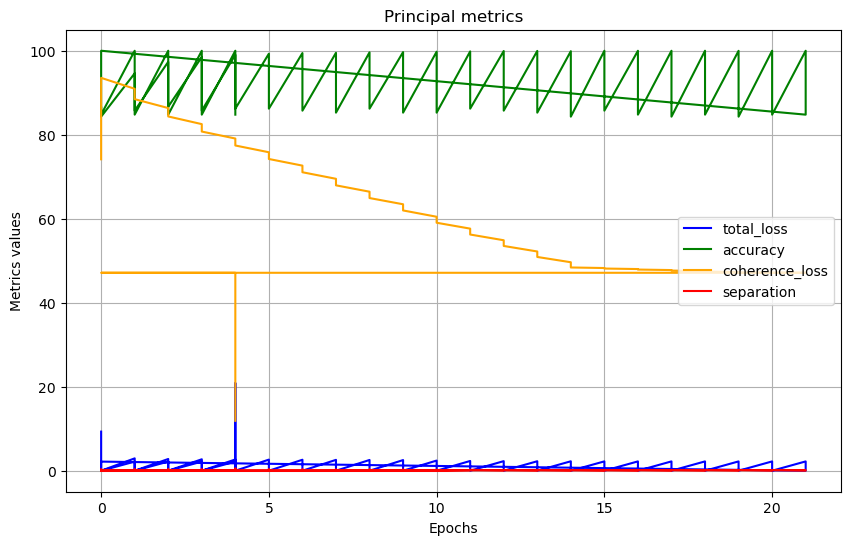

In [4]:
plot_model_selection_metrics(df)

In [34]:
def match_model_with_metrics(log_df, model_file):
    """
    Associe un fichier modèle (par exemple, '7finetuned0.8476.pth') à ses métriques dans le dataframe.
    
    Args:
    - log_df (pd.DataFrame): Dataframe contenant les métriques des époques.
    - model_file (str): Nom du fichier modèle (par exemple, '7finetuned0.8476.pth').

    Returns:
    - dict: Les métriques correspondantes à l'époque du modèle.
    """
    # Extraire l'époque à partir du nom du fichier modèle
    epoch = int(model_file.split('finetuned')[0])
    
    # Filtrer le dataframe pour obtenir les métriques de cette époque
    metrics = log_df[log_df['epoch'] == epoch].iloc[-1].to_dict()  # Dernière itération de l'époque
    
    return metrics

# Exemple d'utilisation
model_file = "7finetuned0.8476.pth"
metrics_for_model = match_model_with_metrics(df, model_file)
print(metrics_for_model)


{'epoch': 7.0, 'time': 0.49765896797180176, 'total_loss': 0.0, 'cross_ent': 0.5204121172428131, 'orthogonal_loss': 295.9932861328125, 'cluster': 0.7597891688346863, 'separation': 0.007260606857016683, 'coherence_loss': 67.93709564208984, 'accuracy': 85.23809523809524, 'l1': 392.0, 'p_dist_pair': 381.570556640625}
